In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
movies = pd.read_csv("/content/movies.csv")
ratings = pd.read_csv("/content/ratings.csv")

In [4]:
# Display the first few rows of each dataset
print("Movies Dataset:")
print(movies.head())
print("\nRatings Dataset:")
print(ratings.head())

Movies Dataset:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings Dataset:
   userId  movieId  rating     timestamp
0       1    296.0     5.0  1.147880e+09
1       1    306.0     3.5  1.147869e+09
2       1    307.0     5.0  1.147869e+09
3       1    665.0     5.0  1.147879e+09
4       1    899.0     3.5  1.147869e+09


In [ ]:
final_dataset = ratings.pivot(index='movieId', columns='userId', values='rating')
final_dataset.fillna(0, inplace=True)  # Fill NaN values with 0
print("\nFinal Dataset (User-Item Matrix):")
print(final_dataset.head())

<ipython-input-5-e4544aa2b479>:1: PerformanceWarning: The following operation may generate 9368581053 cells in the resulting pandas object.
  final_dataset = ratings.pivot(index='movieId', columns='userId', values='rating')


In [ ]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

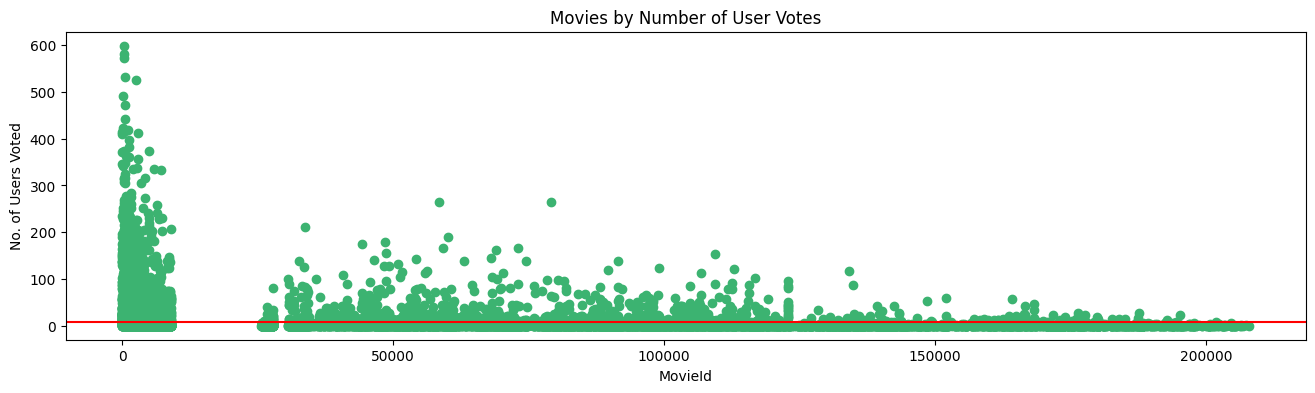

In [7]:
plt.figure(figsize=(16, 4))
plt.scatter(no_user_voted.index, no_user_voted, color='mediumseagreen')
plt.axhline(y=10, color='red')
plt.xlabel('MovieId')
plt.ylabel('No. of Users Voted')
plt.title('Movies by Number of User Votes')
plt.show()

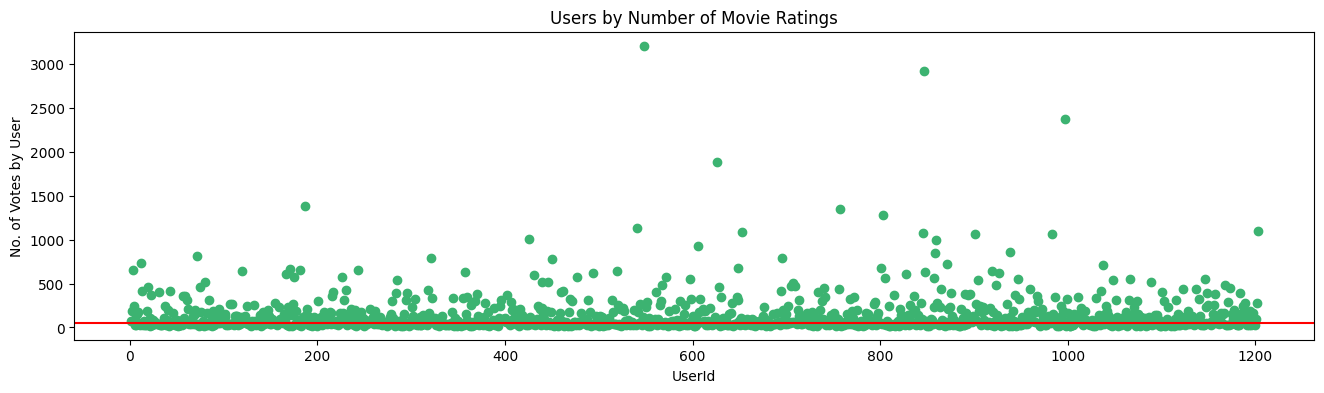

In [8]:
plt.figure(figsize=(16, 4))
plt.scatter(no_movies_voted.index, no_movies_voted, color='mediumseagreen')
plt.axhline(y=50, color='red')
plt.xlabel('UserId')
plt.ylabel('No. of Votes by User')
plt.title('Users by Number of Movie Ratings')
plt.show()

In [9]:
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
user_item_matrix = user_item_matrix.to_numpy()

In [10]:
np.random.seed(42)
train_matrix = user_item_matrix.copy()
test_matrix = np.zeros(user_item_matrix.shape)

for user_id in range(user_item_matrix.shape[0]):
    rated_movies = np.where(user_item_matrix[user_id] > 0)[0]
    test_indices = np.random.choice(rated_movies, size=int(0.2 * len(rated_movies)), replace=False)
    train_matrix[user_id, test_indices] = 0
    test_matrix[user_id, test_indices] = user_item_matrix[user_id, test_indices]

In [11]:
def cosine_similarity(user1, user2):
    dot_product = np.dot(user1, user2)
    norm_user1 = np.linalg.norm(user1)
    norm_user2 = np.linalg.norm(user2)
    return dot_product / (norm_user1 * norm_user2) if norm_user1 != 0 and norm_user2 != 0 else 0

In [12]:
def get_k_nearest_neighbors(train_matrix, target_user_id, k):
    similarities = []
    target_user_ratings = train_matrix[target_user_id]

    for other_user_id in range(train_matrix.shape[0]):
        if other_user_id != target_user_id:  # Don't compare the user with themselves
            similarity = cosine_similarity(target_user_ratings, train_matrix[other_user_id])
            similarities.append((other_user_id, similarity))

    # Sort by similarity in descending order and get top k neighbors
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:k]

In [13]:
def predict_rating(train_matrix, target_user_id, movie_id, k=5):
    neighbors = get_k_nearest_neighbors(train_matrix, target_user_id, k)
    numerator = 0
    denominator = 0

    for neighbor_id, similarity in neighbors:
        if train_matrix[neighbor_id, movie_id] > 0:
            numerator += similarity * train_matrix[neighbor_id, movie_id]
            denominator += similarity

    return numerator / denominator if denominator != 0 else 0


In [14]:
def evaluate_knn(train_matrix, test_matrix, k=5):
    total_squared_error = 0
    count = 0

    for user_id in range(test_matrix.shape[0]):
        for movie_id in range(test_matrix.shape[1]):
            if test_matrix[user_id, movie_id] > 0:  # Only predict for movies in the test set
                predicted_rating = predict_rating(train_matrix, user_id, movie_id, k)

                # Handle potential division by zero in predict_rating
                if predicted_rating is not None and not np.isnan(predicted_rating):
                    total_squared_error += (predicted_rating - test_matrix[user_id, movie_id]) ** 2
                    count += 1

    mse = total_squared_error / count if count != 0 else 0  # Handle zero count to prevent ZeroDivisionError
    return mse
mse = evaluate_knn(train_matrix, test_matrix, k=5)
print(f"Mean Squared Error of KNN model: {mse:.4f}")

KeyboardInterrupt: 

In [ ]:
def recommend_movies(user_id, k=5, num_recommendations=5):
    user_ratings = train_matrix[user_id]
    unrated_movies = np.where(user_ratings == 0)[0]
    movie_scores = {}

    for movie_id in unrated_movies:
        movie_scores[movie_id] = predict_rating(train_matrix, user_id, movie_id, k)

    recommended_movie_ids = sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)[:num_recommendations]
    recommended_movie_ids = [movie_id for movie_id, score in recommended_movie_ids]

     # Get the movie titles for recommended movie IDs
    recommendations = movies[movies['movieId'].isin(recommended_movie_ids)][['title', 'genres']]
    return recommendations


In [ ]:
print("\nTop movie recommendations for User 1:")
print(recommend_movies(user_id=1, k=5, num_recommendations=5))

In [ ]:
import numpy as np

# ... (Your existing functions: predict_rating, evaluate_knn, recommend_movies) ...

def main():
    print("Welcome to the Movie Recommendation System!")

    while True:
        try:
            user_id = int(input("\nEnter the User ID for recommendations (1-{}): ".format(user_item_matrix.shape[0])))
            if user_id < 1 or user_id > user_item_matrix.shape[0]:
                print("Invalid User ID. Please enter a value between 1 and {}.".format(user_item_matrix.shape[0]))
                continue

            # Get recommendations
            print(f"\nTop movie recommendations for User {user_id}:")
            recommendations = recommend_movies(user_id=user_id, k=5, num_recommendations=5) # Corrected function call
            print(recommendations)

            # Prompt to continue or exit
            cont = input("\nWould you like to get recommendations for another user? (yes/no): ").strip().lower()
            if cont != 'yes':
                print("\nThank you for using the Movie Recommendation System!")
                break

        except ValueError:
            print("Invalid input. Please enter a valid User ID.")

# Run the main function
if __name__ == "__main__":
    main()

Welcome to the Movie Recommendation System!


In [ ]:
# Watching History Data
watching_history_data = {
    'userId': [1, 2, 3],
    'watched_movies': [
        [{'title': 'Toy Story', 'genre': 'Animation|Adventure', 'director': 'John Lasseter', 'actors': ['Tom Hanks', 'Tim Allen']}],
        [{'title': 'Heat', 'genre': 'Action|Crime', 'director': 'Michael Mann', 'actors': ['Al Pacino', 'Robert De Niro']}],
        [{'title': 'Father of the Bride', 'genre': 'Comedy|Romance', 'director': 'Charles Shyer', 'actors': ['Steve Martin', 'Diane Keaton']}]
    ]
}

# Ratings and Feedback Data
ratings_feedback_data = {
    'userId': [1, 2, 3],
    'rated_movies': [
        [{'title': 'Toy Story', 'rating': 5, 'feedback': 'Loved the animation!'}],
        [{'title': 'Heat', 'rating': 4, 'feedback': 'Intense and thrilling.'}],
        [{'title': 'Father of the Bride', 'rating': 3, 'feedback': 'Fun, but not my favorite.'}]
    ]
}

# Search Queries and Browsing Behavior
search_behavior_data = {
    'userId': [1, 2, 3],
    'search_queries': [['animated movies', 'comedy movies'], ['crime thrillers', 'drama movies'], ['romantic comedies', 'family movies']],
    'last_browsed_genres': [['Adventure', 'Comedy'], ['Action'], ['Romance']]
}

# Convert Data to DataFrames
watching_history_df = pd.DataFrame(watching_history_data)
ratings_feedback_df = pd.DataFrame(ratings_feedback_data)
search_behavior_df = pd.DataFrame(search_behavior_data)

# Display Data
print("Watching History Data:\n", watching_history_df, "\n")
print("Ratings and Feedback Data:\n", ratings_feedback_df, "\n")
print("Search Behavior Data:\n", search_behavior_df, "\n")


In [ ]:
Build User Profile and Recommendation Functions

# Function to build a user profile
def build_user_profile(user_id):
    """Build a comprehensive user profile based on watching history, ratings, and search behavior."""
    watching_history = watching_history_df[watching_history_df['userId'] == user_id]['watched_movies'].values[0]
    ratings_feedback = ratings_feedback_df[ratings_feedback_df['userId'] == user_id]['rated_movies'].values[0]
    search_behavior = search_behavior_df[search_behavior_df['userId'] == user_id][['search_queries', 'last_browsed_genres']].to_dict(orient='records')[0]

    user_profile = {
        'Watching History': watching_history,
        'Ratings and Feedback': ratings_feedback,
        'Search Behavior': search_behavior
    }

    return user_profile

# Example: Build a user profile for User ID 1
user_id = 1
user_profile = build_user_profile(user_id)
print("\nUser Profile for User ID 1:\n", user_profile)

In [ ]:
Recommendation Functions Based on User Data

# Function to recommend movies based on watching history
def recommend_based_on_history(user_profile):
    """Recommend movies based on genres and actors the user has watched frequently."""
    genres = [movie['genre'] for movie in user_profile['Watching History']]
    actors = [actor for movie in user_profile['Watching History'] for actor in movie['actors']]
    print(f"\nRecommendations based on preferred genres {genres} and actors {actors}.")

# Function to recommend movies based on feedback
def recommend_based_on_ratings(user_profile):
    """Recommend movies similar to those the user rated highly."""
    highly_rated_genres = [movie['title'] for movie in user_profile['Ratings and Feedback'] if movie['rating'] >= 4]
    print(f"\nRecommendations based on highly rated movies {highly_rated_genres}.")

# Function to recommend movies based on search and browsing behavior
def recommend_based_on_search_behavior(user_profile):
    """Recommend movies based on recent searches and last browsed genres."""
    recent_searches = user_profile['Search Behavior']['search_queries']
    last_browsed_genres = user_profile['Search Behavior']['last_browsed_genres']
    print(f"\nRecommendations based on recent searches {recent_searches} and browsing genres {last_browsed_genres}.")

# Example Recommendations
print("\nGenerating recommendations for User ID 1 based on different aspects of user profile...")
recommend_based_on_history(user_profile)
recommend_based_on_ratings(user_profile)
recommend_based_on_search_behavior(user_profile)